In [27]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import collections as mc
import statistics
import datetime as dt
plt.ioff()

numBin = 33
Q1 = 25
Q2 = 50
Q3 = 75

#Dump events & drop useless columns
dump_arrival = pd.read_csv('../../data/interm_data/filtered_skip_deliveries_at_Mzedi.csv')
dump_arrival = dump_arrival.drop(columns=['end','deviceid', 'start'])

#List of origin points
list_origin = dump_arrival.skip_origin.unique().astype(str)
list_origin = list_origin[list_origin!= 'nan']

#Datetime conversion and sorting
dump_arrival.date = pd.to_datetime(dump_arrival.date)#.dt.tz_localize('Africa/Mbabane')
dump_arrival = dump_arrival.sort_values('date')

## PIVOT TABLE
dump_arrival_new = dump_arrival.copy()
dump_arrival_new['values'] = 1
pivot_dump = pd.pivot_table(dump_arrival_new,values='values',index=['date'],columns='skip_origin',aggfunc=np.sum, fill_value=0)

In [28]:
list_origin


array(['Blantyre flea market', 'Queens Guardian shelter',
       'Limbe flea market', 'Milowa', 'Limbe market', 'Kachere market',
       'Pafumbi bus terminal', 'Chirimba market', 'Blantyre market',
       'Chemusa market', 'Mbayani market', 'Bangwe ground',
       'Khama market', 'Nanjiriri market', 'Mbwerela', 'Kayange',
       'Limbe Hard Ware', 'Mibawa Bus terminals', 'Bangwe market',
       'Chilomoni market', 'Thawale market', 'Ndirande market',
       'Chilobwe', 'Kameza round a bout', 'Ndirande ground', 'Malekano',
       'South Lunzu market', 'Nkolokoti market', 'Zingwangwa mosque',
       'Zingwangwa water board', 'Soche market', 'Chiweto',
       'Naizi market', 'BCA market', 'Wenela Bus terminal',
       'Nancholi Police', 'Chimwankhunda mosque', 'Manase Market',
       'Nthukwa market', 'Fargo'], dtype='<U23')

In [29]:
## TIMELINE PLOT
# BCA index 33
plt.close('all')
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)


#BCA market
dates_arrival_skip = pivot_dump[pivot_dump[list_origin[33]]!=0].index

plt.title(list_origin[33])

first_val = min(dates_arrival_skip)
last_val = max(dates_arrival_skip)

# dates_arrival_skip = pivot_dump[pivot_dump.sum(axis=1) != 0].index
# plt.title('Arrivals at Mzedi dump')

#plot timeline of dump arrivals from destination


#BCA market
levels = np.tile([1,1], int(np.ceil(len(dates_arrival_skip)/2)))[:len(dates_arrival_skip)] #+1
ax.vlines(dates_arrival_skip, 0, levels, linestyle='dashed', color=[(0, 0, 0, 0.5)], linewidth=1,label="BCA market arrivals")  # The vertical stems
ax.plot(dates_arrival_skip, np.zeros_like(dates_arrival_skip), "-", color='gray')  #Tick plot



ax.yaxis.set_visible(False) #Hide y axis
ax.spines[["left", "top", "right"]].set_visible(False)#Hide other lines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) #Month interval labels
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.grid(False)
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
#plt.show() #Plot
print([])

[]


In [30]:
#Extract CSV filling data. Each column is a different skip
skip_filling_df = pd.read_csv('../../data/raw_data/Skip-fullness-blantyre-raw.csv')

#Setting the index of the dataframe to the date and convert to datetime
skip_filling_df.set_index('date', inplace=True)
skip_filling_df.index = pd.to_datetime(skip_filling_df.index)


#Remove '.' and dates with all NaN values, convert all to float
skip_filling_df = skip_filling_df.replace('.', np.nan)
skip_filling_df = skip_filling_df.astype(float)
na_columns = skip_filling_df.sum(axis = 0)[skip_filling_df.sum(axis = 0) == 0].index.tolist()
skip_filling_df.dropna(axis=1, how='all', inplace=True)


#List of the skips
skip_dfCol = skip_filling_df.columns
#Number of columns, or skips
numSkips = len(skip_dfCol)

skip_filling_df = skip_filling_df.copy()
skip_filling_df[skip_filling_df < 8] *= 4 / 7
skip_filling_df[skip_filling_df == 8] = 5
min_plot_y = -0.5
max_plot_y = 5.5
binNum = 5 # selected bin for analysis

print(skip_dfCol)

Index(['Bangwe_Organic_1', 'Bangwe_Organic_2', 'Bangwe_inorganic_1',
       'Bangwe_inorganic_2', 'BCA_Organic_1', 'BCA_Organic_2',
       'BCA_inorganic_1', 'BCA_inorganic_2', 'Naizi_Organic_1',
       'Naizi_inorganic_1', 'Chigumula_Organic_1', 'Chigumula_Organic_2',
       'Chigumula_inorganic_1', 'Chigumula_inorganic_2'],
      dtype='object')


In [31]:
##########################################
## Ramp detection and profile extraction
##
## Goals: 
##     - Remove spikes
##    - Detect end of top of ramps, then beginning
##     - Remove derating increases
##     - Find start of ramps 
##########################################
ramps_data = pd.DataFrame(columns = skip_dfCol[range(4)])
comp_df_arr = []

for binNum in [6,7]: #range(len(skip_filling_df.columns)):
    skip_filling_interest = skip_filling_df[skip_dfCol[binNum]].copy().dropna() #Drops NaN from the df
    diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1) #Get the difference in fullness between subsequent datapoints
    diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1) #Get the difference in the negative direction
    td_1 = pd.Timedelta(1, "d") #Define 1 days as a timedelta (pandas tool)


    ## Removing 1 day back to original spikes (positive and negative) Forward pass
    # diff_index_pos = skip_filling_interest.index.to_series().diff() #Index difference between  points (important for NaN)
    # diff_index_neg = skip_filling_interest.index.to_series().diff(periods=-1)
    skip_filling_interest_no_spike = skip_filling_interest.drop(skip_filling_interest[diff_pos - diff_neg == 0][diff_pos != 0].index)#[diff_index_pos == td_1][diff_index_neg == -td_1])


    ## Top ends - forward pass
    indices_no_spike = skip_filling_interest_no_spike.index #Get indices for the current working df series

    i = 0 #Counting
    imax = 0 #Loop protection variable

    top_ends = pd.DataFrame(columns=['top_ends']) #df with the ending of top of ramps
    while i <= len(indices_no_spike) and imax < 600:
        imax = imax+1
        for j in range(len(indices_no_spike)-i-1):
            if skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] >= skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]:
                if i+j+1 == len(indices_no_spike)-1:
                    top_ends.loc[indices_no_spike[i+j+1]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]]
                    i = i+j+1
                    break
                elif skip_filling_interest_no_spike.loc[indices_no_spike[i+j]] == 4 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5:
                    top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                    imax2 = 0
                    while  i+j+1 <= len(indices_no_spike)-1 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5 and imax2 < 600:
                        imax2 = imax2+1
                        if i+j+1 <= len(indices_no_spike)-1:
                            j = j+1
                        else:
                            break
                    i = i + j + 1
                    break
                else:
                    pass
            else:
                top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                i = i+j+1
                break



    ## Move top ends to top beginnings, eliminates plateau from analysis. Backward pass
    top_beginnings = pd.DataFrame(columns=['top_beginnings'])
    i = len(top_ends)-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_ends.index[i])):
            if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] == skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
                pass
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] < skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
                top_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]
                i = i - 1
                #add to list 
                break
            else:
                i = i - 1
                break

    # figure, axis = plt.subplots()
    # skip_filling_interest_no_spike.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    # plt.title(skip_filling_df.columns[binNum])
    # top_ends.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    # axis.legend(bbox_to_anchor=(1.05, 1))
    # plt.show()


    ## Remove derating (backward pass)
    top_beginnings_no_derating = pd.DataFrame(columns=['top_beginnings_no_derating'])
    i = len(top_beginnings[top_beginnings==5])-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])):
            if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] == 4:
                pass
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] < 4:
                top_beginnings_no_derating.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]]
                i = i - 1
                #add to list 
                break
            else:
                i = i - 1
                break

    # figure, axis = plt.subplots()
    # skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    # plt.title(skip_filling_df.columns[binNum])
    # top_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    # axis.legend(bbox_to_anchor=(1.05, 1))
    # plt.show()
    ## Find bottoms (backward pass) walk back for as long as it decreases or equals previous
    bottom_beginnings = pd.DataFrame(columns=['bottom_beginnings'])
    i = len(top_beginnings_no_derating)-1
    imax = 0
    while i >= 0 and imax < 600:
        imax = imax+1
        for j in range(indices_no_spike.get_loc(top_beginnings_no_derating.index[i])):
            if indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1 == 0:
                bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                i = i - 1
                break
            elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1]] <= skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]:
                pass
            else:
                bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                ramps_data.at[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j], (skip_dfCol[binNum])] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
                i = i - 1
                #add to list 
                break

    # figure, axis = plt.subplots()
    # skip_filling_df.plot(ax=axis,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    # plt.title(skip_filling_df.columns[binNum])
    # top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # bottom_beginnings.plot(use_index=True, grid=True, marker='*', ax = axis, linestyle='none', markersize=12)
    # plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
    # axis.legend(bbox_to_anchor=(1.05, 1))
    #plt.show()


    #Join data

    # Ordering both lists by date
    top_beginnings_no_derating.sort_index(inplace = True)
    bottom_beginnings.sort_index(inplace = True)

    # Joining together
    tops = top_beginnings_no_derating.reset_index()
    tops.columns = ['index_top', 'value_top']
    bottoms = bottom_beginnings.reset_index()
    bottoms.columns = ['index_bottom', 'value_bottom']
    POI_df = pd.concat([bottoms,tops], axis = 1)
    
    comp_df = pd.DataFrame(index = POI_df.index_top.to_list() +POI_df.index_bottom.to_list(), columns = [skip_dfCol[binNum]])
    for i in POI_df.index:
        current_ramp = float((POI_df.iloc[i].value_top- POI_df.iloc[i].value_bottom)) / float(((POI_df.iloc[i].index_top-POI_df.iloc[i].index_bottom).days))
        comp_df.loc[POI_df.iloc[i].index_bottom] = current_ramp
        comp_df.loc[POI_df.iloc[i].index_top] = current_ramp
    #print(comp_df)
    comp_df_arr.append(comp_df.copy())

#     list_mc = []
#     for i in POI_df.values.tolist():
#         tuple1 = [mdates.date2num(i[0].to_pydatetime()), i[1]]
#         tuple2 = [mdates.date2num(i[2].to_pydatetime()), i[3]]
#         list_mc.append([tuple1,tuple2])
#     #print(list_mc)
    
#     plt.ioff()
#     fig, ax = plt.subplots(figsize=(12,12))
#     skip_filling_df.plot(ax = ax,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
#     lc = mc.LineCollection(list_mc, color='red')
#     ax.add_collection(lc)
#     plt.title(skip_filling_df.columns[binNum])
#     ax.autoscale_view()
#     ax.xaxis.set_major_locator(mdates.MonthLocator())
#     monthFmt = mdates.DateFormatter("%Y %b")
#     ax.xaxis.set_major_formatter(monthFmt)
#     plt.xlim(skip_filling_interest.index.min(),skip_filling_interest.index.max())
#     plt.ylim(min_plot_y,max_plot_y)
#     ax.set_yticks([0,1,2,3,4,5])
#     #plt.show()
#     #plt.savefig('figures/ramps/'+skip_dfCol[binNum]+'_ramps')
#     #plt.close()    
    
#     ramps_data.loc[skip_dfCol[binNum]] = [(((POI_df.value_top-POI_df.value_bottom).astype(float)/((POI_df.index_top-POI_df.index_bottom).dt.days).astype(float))/4).mean(),len(list_mc),skip_filling_interest_no_spike[skip_filling_interest_no_spike==5].count()/len(skip_filling_interest_no_spike.index), len(skip_filling_interest_no_spike.index)]
#     ramps_data['number_ramps'] = ramps_data['number_ramps'].astype('int')


## Bangwe Matching

In [35]:
ramps_data.sort_index()

,Bangwe_Organic_1,Bangwe_Organic_2,Bangwe_inorganic_1,Bangwe_inorganic_2,BCA_inorganic_1,BCA_inorganic_2
2020-11-17,NaN,NaN,NaN,NaN,0.0,NaN
2021-05-12,NaN,NaN,NaN,NaN,0.0,NaN
2021-06-02,NaN,NaN,NaN,NaN,0.0,0.0
2021-07-13,NaN,NaN,NaN,NaN,0.0,NaN
2021-08-29,NaN,NaN,NaN,NaN,0.0,NaN


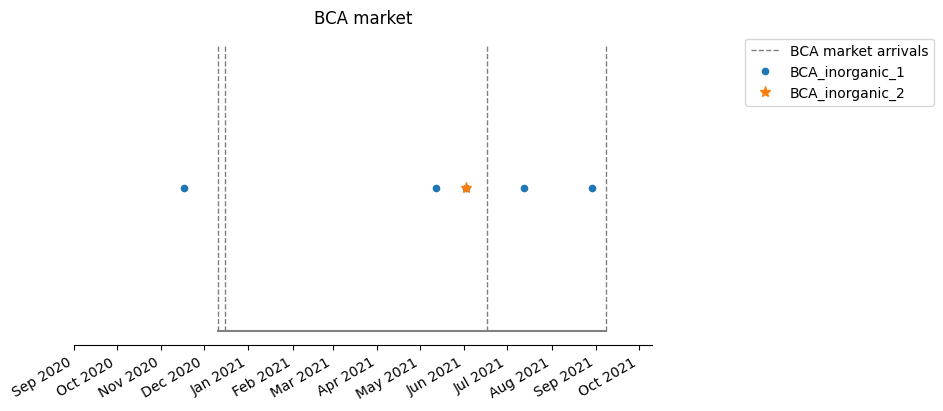

In [33]:

handlelines=[]
i=1
markers = ['.','.','*','*']
for binNum in [6,7]:
    plt.plot(ramps_data.index.to_pydatetime(),ramps_data[skip_dfCol[binNum]]*0 + 0.5, marker=markers[i], linestyle='none', markersize=10-1*i, label=skip_dfCol[binNum])
    i=i+1
plt.legend(bbox_to_anchor=(1.5, 1))
plt.xlim((first_val,last_val)) 
fig = plt.gcf()
#fig.savefig('whole_bangwe')
plt.xlim((dt.date(2020,9,1), dt.date(2021,10,10))) 
fig = plt.gcf()
#fig.savefig('cropped.png')
plt.show()

In [34]:
binNums = [0,2,3]

percent_in0 = []
percent_in2 = []
percent_in3 = []
range_margin = 10
current_bin = 3

date_arrival_skip_sort_interm = pd.DataFrame(index=dates_arrival_skip,columns=['arrivals_no_margin'])
#print(date_arrival_skip_sort_interm[~date_arrival_skip_sort_interm.index.duplicated(keep='first')].sort_index().index.to_series().diff().dt.days.values)
median_between_arrivals = np.nanmedian(date_arrival_skip_sort_interm[~date_arrival_skip_sort_interm.index.duplicated(keep='first')].sort_index().index.to_series().diff().dt.days.values)
#print(median_between_arrivals)

for j in range(range_margin + 1):
    margin = j
    new_dates_arrival_skip = dates_arrival_skip.copy()

    for i in range(margin):
        new_dates_arrival_skip = new_dates_arrival_skip.append(dates_arrival_skip+pd.Timedelta(str(i+1)+'D')).append(dates_arrival_skip-pd.Timedelta(str(i+1)+'D'))


    corr_df = pd.DataFrame(index =new_dates_arrival_skip,columns = ['arrivals_w_margin'])

    corr_df = corr_df[~corr_df.index.duplicated(keep='first')].sort_index()

    corr_df['arrivals_w_margin'] = 1
    #print(corr_df.head(50))


    ramps_series = ramps_data.sum(axis=1)*0 +1
    # ramps_series0 = ramps_data[skip_dfCol[0]].dropna()*0 +1
    ramps_series2 = ramps_data[skip_dfCol[2]].dropna()*0 +1
    ramps_series3 = ramps_data[skip_dfCol[3]].dropna()*0 +1
    
    # len_ramp0 = len(ramps_series0)
    len_ramp2 = len(ramps_series2)
    len_ramp3 = len(ramps_series3)


    # corr_df0 = corr_df.join(ramps_series0.rename('ramps_beg'), how='outer')
    corr_df2 = corr_df.join(ramps_series2.rename('ramps_beg'), how='outer')
    corr_df3 = corr_df.join(ramps_series3.rename('ramps_beg'), how='outer')
    #print(corr_df1.head(50))
    # print(corr_df)
    # print(len(ramps_data))
    
    # percent_in0.append(len(corr_df0[corr_df0.sum(axis=1)>1])/len_ramp0)
    percent_in2.append(len(corr_df2[corr_df2.sum(axis=1)>1])/len_ramp2)
    percent_in3.append(len(corr_df3[corr_df3.sum(axis=1)>1])/len_ramp3)
    
    

# plt.plot(range(range_margin+1),percent_in0, label=skip_dfCol[0])
plt.plot(range(range_margin+1),percent_in2, label=skip_dfCol[2])
plt.plot(range(range_margin+1),percent_in3, label=skip_dfCol[3])
plt.vlines(5.5/2,0,1, color="black",label = "Median of arrivals difference / 2")
plt.xlabel('Margins left and right (days)')
plt.ylabel('Proportion of common points')
plt.grid()
plt.legend(bbox_to_anchor = (1,1))
plt.title('Proportion of skip emptying events \n within padding of skip arrival events')
plt.xlim(0,range_margin)
plt.xticks(range(0,range_margin+1,2))
plt.ylim(0,1)

plt.show()
#print(dates_arrival_skip.)#.index.to_series())#.diff().dt.days.values)

ZeroDivisionError: division by zero